<a herf="https://www.kaggle.com/ventureh/fraud-detection-using-keras-lstm-rnn"> Fraud Detection using Keras LSTM (RNN) <a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
X = pd.read_csv('../../data/creditcard.csv', na_filter=True)

y_original = np.array(X['Class'], dtype='float')

X.drop(['Class'], inplace=True, axis=1)

In [3]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [4]:
rolling_window_size = 10  ### this selects how many historical transactions should be analyzed to judge the transaction at hand -- RNN width

X_interim = np.zeros([(X.shape[0]-rolling_window_size)*10,30], dtype = 'float32')
y = []
ends = []
begs = []
for i in range((X.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    ends.append(end)
    begs.append(beg)
    s = np.array(X[beg:end], dtype='float')
    X_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y.append(y_original[end])
#     print(i)
 
y = np.array(y, dtype='float')
X_interim = X_interim[:,1::]

KeyboardInterrupt: 

In [ ]:
len(y)

In [ ]:
X_tensor = X_interim.reshape(int(np.shape(X_interim)[0]/rolling_window_size), rolling_window_size, np.shape(X_interim)[1])

In [ ]:
X_interim.shape, X_tensor.shape

In [54]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM

In [ ]:
test_train_split = 0.5
stratify = True

if stratify:
    y = np.vstack((range(len(y)),y)).T
    y_pos = y[y[:,1]==1]
    y_neg = y[y[:,1]==0]
    
    y_pos = y_pos[np.random.choice(y_pos.shape[0], int(y_pos.shape[0]*test_train_split), replace=False),:]
    y_neg = y_neg[np.random.choice(y_neg.shape[0], int(y_neg.shape[0]*test_train_split), replace=False),:]
    
    train_idx = np.array(np.hstack((y_pos[:,0],y_neg[:,0])), dtype='int')
    
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx,1]
    y_test = np.delete(y, train_idx, axis=0)
    y_test = y_test[:,1]
else: 
    train_idx = np.random.choice(X_tensor.shape[0], int(X_tensor.shape[0]*test_train_split), replace=False)
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx]
    y_test = np.delete(y, train_idx, axis=0)

del (X_tensor, y, stratify, test_train_split, train_idx, y_neg, y_pos)

In [ ]:
### Hyperparameters Tuning
# First test optimal epochs holding everything else constant
# Dropout: 0.1-0.6
# GradientClipping: 0.1-10
# BatchSize: 32,64,128,256,512 (power of 2)


### Train LSTM using Keras 2 API ###
model = Sequential()
model.add(LSTM(20, input_shape=X_train.shape[1:], kernel_initializer='lecun_uniform', activation='relu', kernel_regularizer=regularizers.l1(), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
#model.add(LSTM(12, activation='relu', return_sequences=True))
#model.add(LSTM(8, activation='relu'))
model.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #optimizer='rmsprop'
print(model.summary())

In [ ]:
result = model.fit(X_train, y_train, epochs=100, batch_size=10000, class_weight={0 : 1., 1: float(int(1/np.mean(y_train)))}, validation_split=0.3)

In [37]:
import matplotlib.pyplot as plt

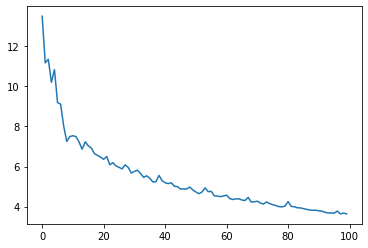

Loss Value changed from 13.498317 to  3.639803


In [56]:
plt.plot(result.history["loss"])
plt.show()
print("Loss Value changed from %f to " %result.history["loss"][0] ,"%f" %result.history["loss"][-1])

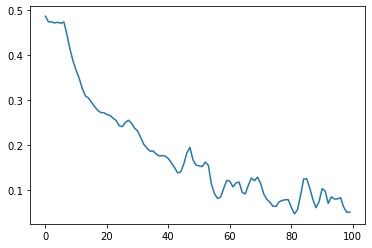

Accuracy Value changed from 0.486898 to  0.051656


In [57]:
plt.plot(result.history["accuracy"])
plt.show()
print("Accuracy Value changed from %f to " %result.history["accuracy"][0] ,"%f" %result.history["accuracy"][-1])

In [46]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

### test AUC ###
from sklearn import metrics 

fpr, tpr, thresholds = metrics.roc_curve(y_train, train_predict, pos_label=1)
print('TRAIN | AUC Score: ' + str((metrics.auc(fpr, tpr))))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict, pos_label=1)
print('TEST | AUC Score: ' + str((metrics.auc(fpr, tpr))))

TRAIN | AUC Score: 0.613942472891722
TEST | AUC Score: 0.6094695489841788


## Test on Simulated Transactions

In [5]:
import pickle
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [7]:
from tqdm import tqdm

In [8]:
path = os.getcwd()
path

'/home/m.shah/projects/models/kaggle-models'

In [9]:
dfs = []

for filename in glob.glob(os.path.join(path, "../../data/simulated-data-raw/", "data", "*.pkl")):
    with open(filename, 'rb') as f:
        temp = pd.read_pickle(f)
        dfs.append(temp)
df = pd.DataFrame()
df = df.append(dfs)

In [10]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


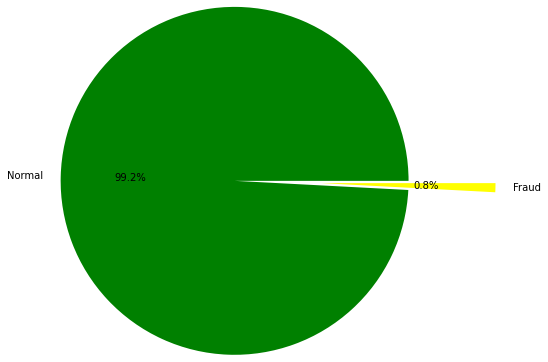

In [11]:
portions = df["TX_FRAUD"].value_counts().to_dict()
plt.pie(portions.values(), 
        portions.keys(),
        labels = ["Normal", "Fraud"], 
        radius = 2,
        autopct='%1.1f%%',
       colors = ["green", "yellow"])
plt.show()

In [12]:
customer_tx_count = df["CUSTOMER_ID"].value_counts().to_dict()

<AxesSubplot:ylabel='Density'>

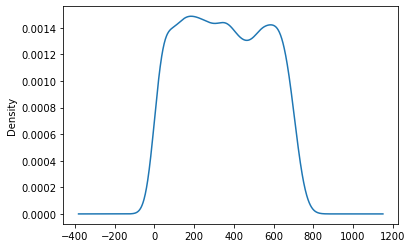

In [13]:
pd.Series(list(customer_tx_count.values())).plot(kind = 'density')

In [14]:
class PreProcessor:    
    def __init__(self):
        pass
    def noramlize(self):
        pass
    
    def pre_process(self, 
                    input_data, 
                    feature_columns,
                    label_columns,
                   categorical = None):
        data_x = pd.DataFrame(input_data[feature_columns])
        data_y= pd.DataFrame(input_data[label_columns])
        #OneHotEncoding
        if categorical[0] is not None:
            data_x = pd.get_dummies(data_x, columns = categorical[0])
        if categorical[1] is not None:
            data_y = pd.get_dummies(data_y, columns = categorical[1])
        return data_x, data_y

In [15]:
#Feature Define
if "WEEK_DAY" not in df.columns:
    df.insert(7, "WEEK_DAY", df["TX_DATETIME"].apply(lambda x : x.weekday()))

#Feature Selection
selected_features = ["CUSTOMER_ID", 
                     "TERMINAL_ID", 
                     'TX_AMOUNT', 
                     'TX_TIME_SECONDS', 
                     'TX_TIME_DAYS', 
                     "WEEK_DAY"]

In [16]:
pre_processor = PreProcessor()

data_x, data_y = pre_processor.pre_process(df.iloc[:,:9], 
                                           selected_features,
                                           ["TX_FRAUD"],
                                          categorical = [["WEEK_DAY"], None])
data_y = np.array(data_y)

# train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2)

In [17]:
data_x.shape, data_y.shape

((1754155, 12), (1754155, 1))

In [19]:
#PARAMS
time_window = 128 

train_samples, n_features = data_x.shape[0], data_x.shape[1]
params = train_samples, time_window, n_features

# test_samples = test_x.shape[0]
# test_params =  test_samples, time_window, n_features


params

(1754155, 128, 12)

In [20]:
input_x = np.zeros([(data_x.shape[0]-rolling_window_size)*10, n_features], dtype = 'float32')
input_y = []
input_x.shape

(17541450, 12)

In [21]:
range(data_x.shape[0]-rolling_window_size)

range(0, 1754145)

In [22]:
(data_x.shape[0]-rolling_window_size)

1754145

In [23]:
finishes = range(10,input_x.shape[0]+1)
finishes = np.array(finishes)

In [24]:
starts = np.array(range(0, input_x.shape[0]-9))

In [25]:
len(starts) == len(finishes)

True

In [26]:
# starts = []
# finishes = []

for i in tqdm(range(data_x.shape[0]-rolling_window_size)):
#     start = 0+i
#     finish = start+rolling_window_size
#     if finish in finishes:
#         print(finish, "i:", i)
#     finishes.append(finish)
#     starts.append(start)
    s = np.array(data_x[beg:end], dtype='float')
    input_x[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    input_y.append(data_y[end, ])
#     print(x_interim)
#     print(y_interim)
#     print(i)
# data_y = np.array(y, dtype='float')
# data_x_interim = X_interim[:,1::]

100%|█████████████████████████████████████████████████████████████████████████| 1754145/1754145 [15:24<00:00, 1897.69it/s]


In [32]:
input_x.shape[0] == 10*len(input_y)

True

In [33]:
with open("input_x.pickle", "wb") as f:
    pickle.dump(input_x, f)

In [34]:
with open("input_y.pickle", "wb") as f:
    pickle.dump(input_y, f)

In [35]:
input_x[1,:]

array([4.606000e+03, 9.942000e+03, 5.733000e+01, 1.148203e+06,
       1.300000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00],
      dtype=float32)

In [36]:
input_x_tensor = input_x.reshape(int(np.shape(input_x)[0]/rolling_window_size), rolling_window_size, np.shape(input_x)[1])

In [49]:
    train_indc = np.random.choice(input_x_tensor.shape[0], int(input_x_tensor.shape[0]*test_train_split), replace=False)
type(train_indc[0])
type(input_y)
input_y = np.array(input_y)

In [50]:
test_train_split = 0.5
stratify = False

if stratify:
    y = np.vstack((range(len(y)),y)).T
    y_pos = y[y[:,1]==1]
    y_neg = y[y[:,1]==0]
    
    y_pos = y_pos[np.random.choice(y_pos.shape[0], int(y_pos.shape[0]*test_train_split), replace=False),:]
    y_neg = y_neg[np.random.choice(y_neg.shape[0], int(y_neg.shape[0]*test_train_split), replace=False),:]
    
    train_idx = np.array(np.hstack((y_pos[:,0],y_neg[:,0])), dtype='int')
    
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx,1]
    y_test = np.delete(y, train_idx, axis=0)
    y_test = y_test[:,1]
else: 
    train_indc = np.random.choice(input_x_tensor.shape[0], int(input_x_tensor.shape[0]*test_train_split), replace=False)
    X_train2 = input_x_tensor[train_indc, :, :]
    X_test2 = np.delete(input_x_tensor, train_indc, axis=0)
    y_train2 = input_y[train_indc]
    y_test2 = np.delete(input_y, train_indc, axis=0)

# del (X_tensor, y, stratify, test_train_split, train_idx, y_neg, y_pos)

In [52]:
X_train2.shape, len(y_train2)

((877072, 10, 12), 877072)

In [56]:
### Hyperparameters Tuning
# First test optimal epochs holding everything else constant
# Dropout: 0.1-0.6
# GradientClipping: 0.1-10
# BatchSize: 32,64,128,256,512 (power of 2)


### Train LSTM using Keras 2 API ###
model2 = Sequential()
model2.add(LSTM(20, input_shape=X_train2.shape[1:], kernel_initializer='lecun_uniform', activation='relu', kernel_regularizer=regularizers.l1(), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
#model.add(LSTM(12, activation='relu', return_sequences=True))
#model.add(LSTM(8, activation='relu'))
model2.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #optimizer='rmsprop'
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2640      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
result = model2.fit(X_train2, y_train2, epochs=1, batch_size=10000, validation_split=0.3)

62/62 [==============================] - 28s 362ms/step - loss: 32750.2891 - accuracy: 0.5636 - val_loss: 3.7453 - val_accuracy: 1.0000


In [70]:
yy = model2.predict(X_test2[:100])

In [72]:
yy[yy <= 0.5] = 1

In [73]:
yy

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],